# Práctico de Introducción al Aprendizaje Automático

## Reducción de Emisiones Contaminantes por el Uso de Biocombustibles en Transporte de Cargas y Pasajeros

### Mentoria DiploDatos FAMAF

#### Propósito:

En este práctico se propone aplicar los fundamentos del aprendizaje automático con el objetivo de poder prónosticar la demanda de combustible partiendo de los datos disponibles y de datos que se puedan incorporar de fuentes públicas.

Para esto se emplearán 2 modelos de regresión empleando la librería sklearn, uno propuesto para obtener un baseline y el otro para obtener un modelo mejorado (a criterio del equipo).

Se parte de la tabla de transacciones con una limpieza y curación previa realizada en el práctico de Exploración y Curación.
Sin embargo, es posible que nos encontremos con la necesidad de realizar otros tratamientos a los datos por algunas particularidades que no saltaron al momento; pero que ahora teniendo un objetivo definido del uso de los datos, seguramente se tendrán en consideración.

Pasos sugeridos a seguir:
1. ***Preprocesamiento de los datos:***

        1.1. Evaluar la necesidad de curación de datos: De entrada, sugiero revisar los valores de "cantidad", los cuales no podrían ser superiores a la capacidad del tanque; y veamos cómo imputar estos valores que están fuera de la capacidad del tanque.
        1.2. Transformación de valores categóricos, booleanos, etc.
        1.3. Feature engineering: creación de otros features; indagar y emplear el conocimiento de dominio que tiene el equipo para incorporar otros features que sean útiles para enriquecer el modelo. Tener en cuenta la agregación de datos que se debe realizar para obtener datos periódicos (quincenales, semanales, diarios).
        1.4. Seleccionar features mediante algún método de filtrado: considerar la correlación y asociación de las variables independientes (variables explicativas o regresoras) con la variable dependiente (variable respuesta), así como la multicolinealidad entre variables regresoras. También recuerde la importancia de la variabilidad en los datos, aquellas variables cuyos valores estén muy concentrados en un valor particular, no serán de mucha utilidad, al igual que aquellas variables que tienen gran cantidad de datos nulos (de ser posible realice alguna técnica de imputación, de lo contrario se debe eliminar).
        1.5. Escalado y normalización de los datos, de ser necesario.
        1.6. Partición del dataset en entrenamiento y test.
        

2. ***Entrenamiento y testeo de modelos.***
        Se muestra un ejemplo con pronóstico de la demanda quincenal (probar con periodicidad diaria).   
3. ***Pruebe a cambiar features u otro algoritmo de regresión para intentar una mejora en la predicción, y hacer una comparativa de modelos*** (opcional)
4. ***Utilice la grilla de hiperparámetros y la validación cruzada para encontrar el conjunto de hiperparámetros del modelo, que mejor metrica reporte.***
        Ver: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html    

In [1]:
#!pip install tabulate

In [2]:
import pandas as pd
import numpy as np
import warnings
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, median_absolute_error, explained_variance_score, max_error
# Importar acá las librerías que sean necesarias


In [3]:
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 50)

In [4]:
# Lectura de datos (resultantes de la limpieza y curación)
transacciones_df = pd.read_pickle('data/sis_transa_201801_202007_merged.pkl.zip')
print(transacciones_df.info())
transacciones_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2805130 entries, 0 to 2819197
Data columns (total 29 columns):
 #   Column            Dtype         
---  ------            -----         
 0   id_transaccion    uint16        
 1   id_vehiculo       uint32        
 2   id_usuario        uint16        
 3   id_equipo         uint32        
 4   id_bomba          uint32        
 5   id_tanque         uint32        
 6   producto          float32       
 7   fecha_hora        datetime64[ns]
 8   fecha_hora_stop   datetime64[ns]
 9   departamento      object        
 10  codigo_error      object        
 11  cantidad          float32       
 12  volume_start      float32       
 13  volume_stop       float32       
 14  temp_start        float32       
 15  temp_stop         float32       
 16  geo_latitud       float32       
 17  geo_longitud      float32       
 18  baja_transaccion  bool          
 19  id_empresa        float64       
 20  current_firmware  object        
 21  delay_ue

,id_transaccion,id_vehiculo,id_usuario,id_equipo,id_bomba,id_tanque,producto,fecha_hora,fecha_hora_stop,departamento,codigo_error,cantidad,volume_start,volume_stop,temp_start,temp_stop,geo_latitud,geo_longitud,baja_transaccion,id_empresa,current_firmware,delay_ue,geo_latitude,geo_longitude,hash_empresa,baja_empresa,segmento,baja_vehiculo,main_id
0,6974,39920,1045,139,174,134,1.0,2018-01-01 08:27:00,NaT,0000,BF,115.972000,NaN,NaN,NaN,NaN,NaN,NaN,False,43.0,,0.0,NaN,NaN,1899d5678099a1705184deaa57573548,False,Constructoras,False,000005
1,6975,39819,1041,139,174,134,1.0,2018-01-01 13:56:00,NaT,0000,BF,127.906998,NaN,NaN,NaN,NaN,NaN,NaN,False,43.0,,0.0,NaN,NaN,1899d5678099a1705184deaa57573548,False,Constructoras,False,000002
2,6976,39931,1055,139,174,134,1.0,2018-01-01 16:54:00,NaT,0000,BF,65.570999,NaN,NaN,NaN,NaN,NaN,NaN,False,43.0,,0.0,NaN,NaN,1899d5678099a1705184deaa57573548,False,Constructoras,False,000016
3,6977,39922,1047,139,174,134,1.0,2018-01-01 20:38:00,NaT,0000,BF,71.700996,NaN,NaN,NaN,NaN,NaN,NaN,False,43.0,,0.0,NaN,NaN,1899d5678099a1705184deaa57573548,False,Constructoras,False,000007
4,5250,41504,436,111,100,81,1.0,2018-01-01 00:23:00,NaT,0001,C1,360.018005,NaN,NaN,NaN,NaN,NaN,NaN,False,27.0,,0.0,NaN,NaN,48a207f3a91979ecf532170652d04745,False,Transporte,False,000355


## PREPROCESAMIENTO DE DATOS

### Curación de datos

In [5]:
print(f'Número de tanques: {transacciones_df.id_tanque.nunique()} - Número de empresas: {transacciones_df.id_empresa.nunique()}')

Número de tanques: 707 - Número de empresas: 245


In [6]:
# Revisión del porcentaje de valores nulos
transacciones_df.isnull().sum()/len(transacciones_df)*100

id_transaccion       0.000000
id_vehiculo          0.000000
id_usuario           0.000000
id_equipo            0.000000
id_bomba             0.000000
id_tanque            0.000000
producto             0.349609
fecha_hora           0.000000
fecha_hora_stop     36.655877
departamento         0.000000
codigo_error         0.000000
cantidad             0.000000
volume_start        36.655841
volume_stop         36.655841
temp_start          36.655841
temp_stop           36.655841
geo_latitud         45.151669
geo_longitud        45.151740
baja_transaccion     0.000000
id_empresa           0.000000
current_firmware     0.000000
delay_ue             0.000000
geo_latitude        99.236827
geo_longitude       99.236827
hash_empresa         0.000000
baja_empresa         0.000000
segmento             0.000000
baja_vehiculo        9.563799
main_id              9.563799
dtype: float64

In [7]:
# Estadística descriptiva por productos
transacciones_df.groupby('producto')['cantidad'].agg({'count', 'mean', 'std', 'min', 'max'})

,count,mean,std,min,max
producto,,,,,
0.0,2047013,157.500961,508.850739,0.00,100000.000000
1.0,478271,111.809914,270.376740,0.00,19033.324219
2.0,174732,119.980919,208.634216,0.00,9999.216797
3.0,94322,60.104965,121.017006,0.00,11924.480469
4.0,742,173.243744,3669.826416,0.00,100000.000000
5.0,68,0.000000,0.000000,0.00,0.000000
6.0,92,0.000000,0.000000,0.00,0.000000
7.0,1,0.080000,NaN,0.08,0.080000
8.0,78,336.560181,837.172913,0.00,5865.000000


Chequeemos valores máximos en las transacciones, de acuerdo a la capacidad máxima del tanque.

¿Todos los productos registrados en las transacciones corresponde a combustible? ¿O existe otro tipo de producto que no es combustible? 

In [8]:
tanques_df = pd.read_pickle('data/dataframe_tanques.pkl.zip')

In [9]:
tanques_df.head()

,id_tanque,id_equipo,tanque,producto,capacidad,log_interval,nivel_alarma
0,101525,669,B,1,10000.099609,10000.099609,0.0
1,101833,764,5,1,8000.000000,8000.000000,3200.0
2,101496,662,1,0,50000.000000,50000.000000,0.0
3,101495,661,1,0,25000.000000,25000.000000,0.0
4,101522,669,8,1,10000.099609,10000.099609,0.0


Verifiquemos si encontramos todos los tanques registrados en la tabla de tanques.

In [10]:
print(f'Capacidad mínima y máxima de los tanques: min={tanques_df.capacidad.min()} - max={tanques_df.capacidad.max()}')
print(f'Número de tanques en la tabla de tanques: {tanques_df.shape} vs número de tanques en la tabla de transacciones: {transacciones_df.id_tanque.nunique()}')
print(f'Número de tanques en la tabla de transacciones registradas en la tabla de tanques: {len(set(tanques_df.id_tanque).intersection(transacciones_df.id_tanque))}')

Capacidad mínima y máxima de los tanques: min=0.0 - max=104000.0
Número de tanques en la tabla de tanques: (1561, 7) vs número de tanques en la tabla de transacciones: 707
Número de tanques en la tabla de transacciones registradas en la tabla de tanques: 666


Se encuentran id de tanques en las transacciones que no están registradas en la tabla de tanques: 666 tanques registrados de 707 

In [11]:
# Obtenemos la lista de Id de los tanques registrados para proceder a verificar los topes máximos en las transacciones
lista_id_tanques = set(tanques_df.id_tanque).intersection(transacciones_df.id_tanque)

# transacc_tanques_intersecc_df = pd.merge(transacciones_df, tanques_df, how='inner', on=['id_tanque'])
print(f'Al realizar la intersección de los dataframes obtenemos que el {transacciones_df.id_tanque.isin(tanques_df.id_tanque).sum()/len(transacciones_df)*100:.2f}'
      f'% de las transacciones son de tanques registrados.')

Al realizar la intersección de los dataframes obtenemos que el 98.86% de las transacciones son de tanques registrados.


In [12]:
# Se verifican las cantidades máximas en las transacciones en base a las capacidades de los tanques
def cantidad_vs_capacidad(transacciones_df, tanques_df, lista_id_tanques):
    cont = 0
    for Id in lista_id_tanques:
        cap_max = tanques_df[tanques_df['id_tanque'] == Id]['capacidad']
        cant = transacciones_df[transacciones_df['id_tanque'] == Id]['cantidad']
        cont += (cant  > cap_max.values[0]).sum()
    return cont

lista_id_tanques = set(tanques_df.id_tanque).intersection(transacciones_df.id_tanque)
cont = cantidad_vs_capacidad(transacciones_df, tanques_df, lista_id_tanques)

print(f'Número de transacciones con "cantidad" superior a la capacidad del tanque: {cont}')

Número de transacciones con "cantidad" superior a la capacidad del tanque: 39341


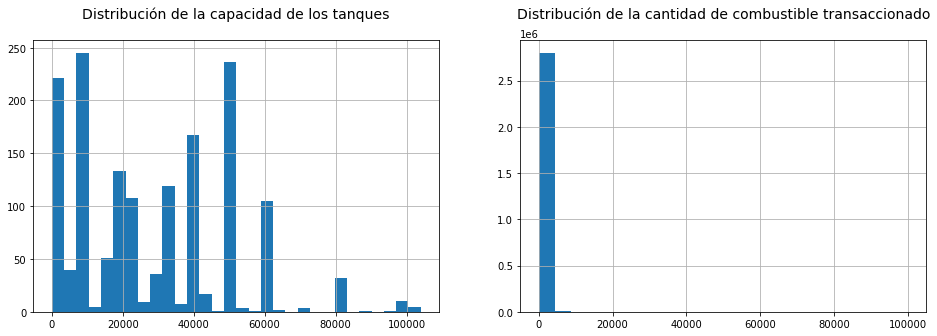

In [13]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(16,5))
tanques_df.capacidad.hist(bins=30, ax=axs[0]), 
axs[0].set_title('Distribución de la capacidad de los tanques\n', fontsize=14)
transacciones_df.cantidad.hist(bins='sturges', ax=axs[1])
axs[1].set_title('Distribución de la cantidad de combustible transaccionado\n', fontsize=14)
plt.show()

In [14]:
# Se imputa la capacidad del tanque para las cantidades de las transacciones que sobrepasan el valor de la capacidad del tanque
for Id in lista_id_tanques:
    cap_max = tanques_df[tanques_df['id_tanque'] == Id]['capacidad']
    cant = transacciones_df[transacciones_df['id_tanque'] == Id]['cantidad']
    transacciones_df.loc[(transacciones_df['id_tanque'] == Id) & (transacciones_df['cantidad'] > cap_max.values[0]), 'cantidad'] = cap_max.values[0]

# Verificamos que no quede ningún valor fuera de rango
cont = cantidad_vs_capacidad(transacciones_df, tanques_df, lista_id_tanques)
print(f'Número de transacciones con "cantidad" superior a la capacidad del tanque: {cont}')

Número de transacciones con "cantidad" superior a la capacidad del tanque: 0


In [15]:
transacciones_df.segmento.value_counts()

Estaciones de Servicio    1006587
Transporte                 809409
Oil and Gas                254184
Constructoras              226636
Agro                       207214
Industria                  159431
Demo                        85519
Mineria                     48663
Telcos                       7487
Name: segmento, dtype: int64

In [16]:
# Columnas seleccionadas 
columns_sel = ['producto', 'fecha_hora', 'cantidad', 'segmento',]
data = transacciones_df[columns_sel]
data = data.sort_values('fecha_hora', ascending=True)
data.head()

,producto,fecha_hora,cantidad,segmento
4,1.0,2018-01-01 00:23:00,360.018005,Transporte
60,0.0,2018-01-01 01:40:00,71.621002,Transporte
61,0.0,2018-01-01 01:45:00,35.368000,Transporte
1429,0.0,2018-01-01 02:05:00,600.046997,Transporte
5,1.0,2018-01-01 02:28:00,190.229996,Transporte


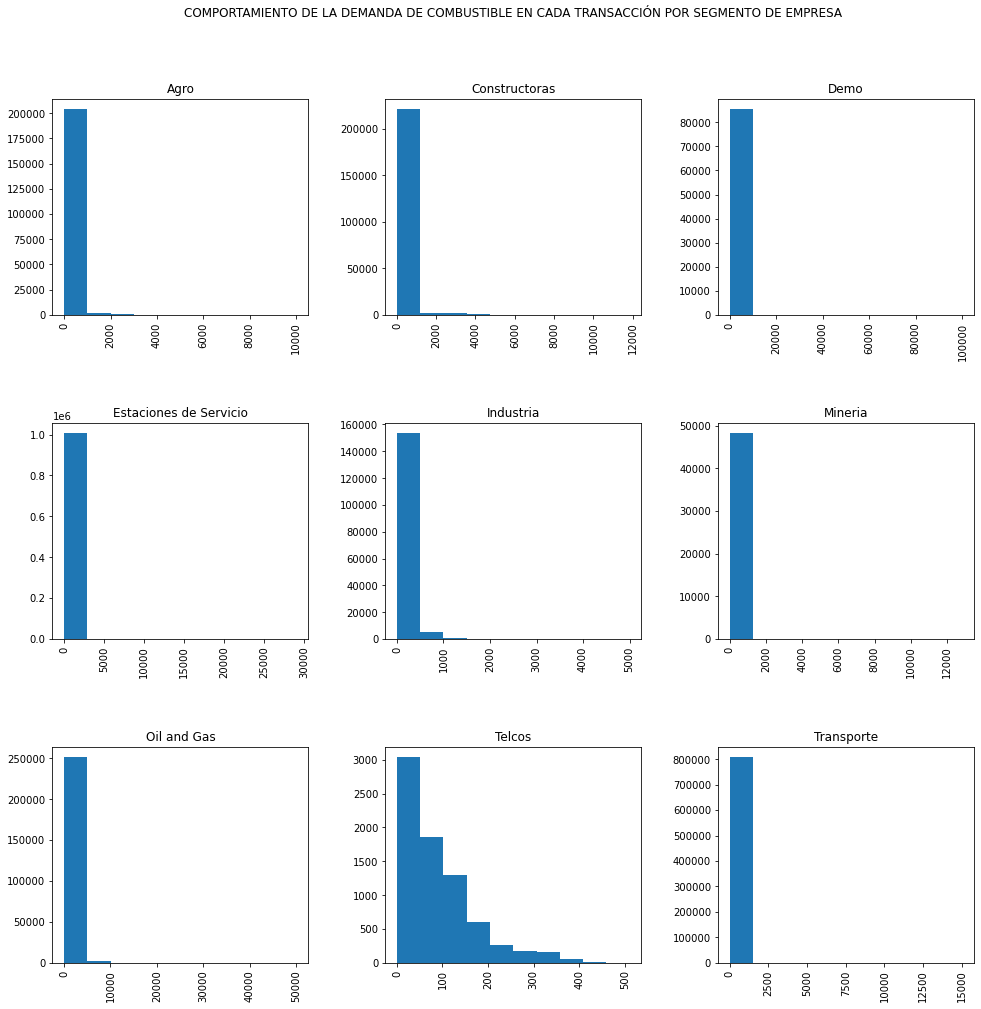

In [17]:
transacciones_df.hist(column='cantidad', by='segmento', figsize=(16,16))
plt.suptitle('COMPORTAMIENTO DE LA DEMANDA DE COMBUSTIBLE EN CADA TRANSACCIÓN POR SEGMENTO DE EMPRESA')
plt.show()

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2805130 entries, 4 to 1567363
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   producto    float32       
 1   fecha_hora  datetime64[ns]
 2   cantidad    float32       
 3   segmento    object        
dtypes: datetime64[ns](1), float32(2), object(1)
memory usage: 85.6+ MB


In [19]:
data.isnull().sum()/len(data)*100

producto      0.349609
fecha_hora    0.000000
cantidad      0.000000
segmento      0.000000
dtype: float64

### Feature Engineering

#### Obtención de la data periódica

In [20]:
dicc_operations = {'producto': lambda x: statistics.mode(x),
                   'cantidad': 'sum',
                   'segmento': lambda x: statistics.mode(x),
                  }

data_period = data[data['segmento']=='Estaciones de Servicio'].set_index('fecha_hora').resample('2W').agg(dicc_operations).reset_index() #.apply(logic)
data_period.head()

,fecha_hora,producto,cantidad,segmento
0,2018-01-07,0.0,82634.898438,Estaciones de Servicio
1,2018-01-21,0.0,168164.343750,Estaciones de Servicio
2,2018-02-04,0.0,166375.609375,Estaciones de Servicio
3,2018-02-18,0.0,178051.234375,Estaciones de Servicio
4,2018-03-04,0.0,161348.343750,Estaciones de Servicio


In [21]:
data_period.segmento.unique()

array(['Estaciones de Servicio'], dtype=object)

In [22]:
data_period.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   fecha_hora  64 non-null     datetime64[ns]
 1   producto    64 non-null     float32       
 2   cantidad    64 non-null     float32       
 3   segmento    64 non-null     object        
dtypes: datetime64[ns](1), float32(2), object(1)
memory usage: 1.6+ KB


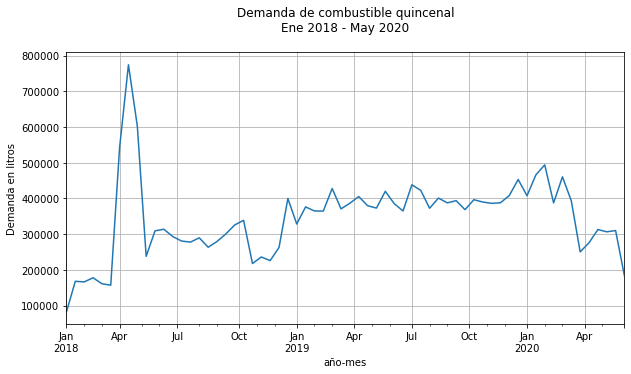

In [23]:
data_period.set_index('fecha_hora').cantidad.plot(figsize=(10,5))
plt.title('Demanda de combustible quincenal\nEne 2018 - May 2020\n'), plt.xlabel('año-mes'), plt.ylabel('Demanda en litros')
plt.grid()
plt.show()

https://machinelearningmastery.com/basic-feature-engineering-time-series-data-python/

#### Creación de nuevos features

In [24]:
# Algunas features extras que se pueden obtener a partir del mes y año
# Extracción de mes y año
data_period['year'] = data_period['fecha_hora'].dt.year
data_period['month'] = data_period['fecha_hora'].dt.month
data_period['weekofyear'] = data_period['fecha_hora'].dt.weekofyear
data_period['weekday'] = data_period['fecha_hora'].dt.weekday
data_period['quarter'] = data_period['fecha_hora'].dt.quarter
data_period['is_quarter_start'] = data_period['fecha_hora'].dt.is_quarter_start
data_period['is_quarter_end'] = data_period['fecha_hora'].dt.is_quarter_end

# Otras features para considerar en otros periodos de tiempo
data_period['day'] = data_period['fecha_hora'].dt.day
data_period['dayofyear'] = data_period['fecha_hora'].dt.dayofyear
# data_period['dayofweek'] = data_period['fecha_hora'].dt.dayofweek
data_period['is_month_start'] = data_period['fecha_hora'].dt.is_month_start
data_period['is_month_end'] = data_period['fecha_hora'].dt.is_month_end
# data_period['is_year_start'] = data_period['fecha_hora'].dt.is_year_start
# data_period['is_year_end'] = data_period['fecha_hora'].dt.is_year_end

**Promedios Móviles SImples (SMA)**

Es una medida de análisis que suaviza los valores de los datos creando un promedio que se actualiza constantemente con los últimos n periodos. El promedio se toma durante un período de tiempo específico, como 7 días, 30 minutos, 4 semanas o cualquier período de tiempo que se elija.

También existen los promedios móviles exponenciales (EMA), investigue y trate de incorporarlos al análisis.

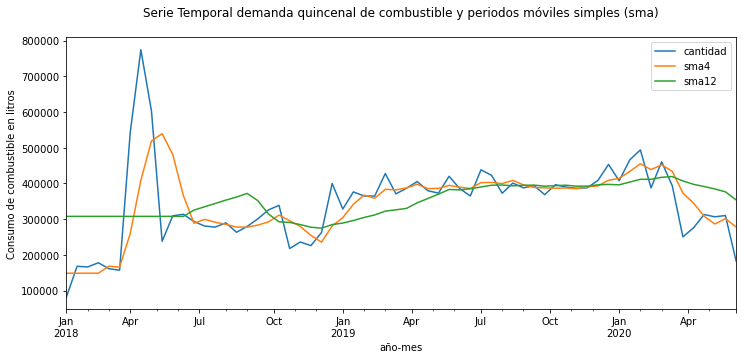

In [25]:
# Creación de medias móviles de 4 y 12 periodos
data_period['sma4'] = data_period.cantidad.rolling(4).mean().fillna(method='backfill')
data_period['sma12'] = data_period.cantidad.rolling(12).mean().fillna(method='backfill')
data_period[['cantidad', 'sma4', 'sma12', 'fecha_hora']].set_index('fecha_hora').plot(figsize=(12, 5))
plt.xlabel('año-mes'), plt.ylabel('Consumo de combustible en litros')
plt.title('Serie Temporal demanda quincenal de combustible y periodos móviles simples (sma)\n')
plt.show()

El sma4 constituye un promedio móvil calculado para 2 meses (4 x quincena)

Observe que a mayor numero de periodos el suavizamiento de la curva es mayor.

- ***Veamos otros features:***

*El pct_change:* calcula el cambio relativo de la variable respecto al valor de n periodos anteriores ((Vt - Vn)/Vn)

*Los lags, desfases o retardos:* el conjunto de observaciones en una serie de tiempo se rezaga n periodos, y se emplean para analizar la autocorrelación de la serie.

In [26]:
# Creación de otros features
data_period['pct_change'] = data_period['cantidad'].pct_change(periods=1, fill_method='pad', limit=None, freq=None)

def get_lags(data, column, n_lags=5):
    lags_data = data.copy()    
    for i in range(1, n_lags+1):
        col = 'lag_' + str(i)
        lags_data[col] = lags_data[column].shift(i)    
    return lags_data

data_period = get_lags(data_period, 'cantidad', 4)

# Con la creación de estos features se generan algunos valores nulos, imputemos dichos valores. ¿Es correcta está imputación? ¿Cuál usarías?
data_period = data_period.fillna(method='backfill')
print(data_period.info())
data_period.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   fecha_hora        64 non-null     datetime64[ns]
 1   producto          64 non-null     float32       
 2   cantidad          64 non-null     float32       
 3   segmento          64 non-null     object        
 4   year              64 non-null     int64         
 5   month             64 non-null     int64         
 6   weekofyear        64 non-null     int64         
 7   weekday           64 non-null     int64         
 8   quarter           64 non-null     int64         
 9   is_quarter_start  64 non-null     bool          
 10  is_quarter_end    64 non-null     bool          
 11  day               64 non-null     int64         
 12  dayofyear         64 non-null     int64         
 13  is_month_start    64 non-null     bool          
 14  is_month_end      64 non-nul

,fecha_hora,producto,cantidad,segmento,year,month,weekofyear,weekday,quarter,is_quarter_start,is_quarter_end,day,dayofyear,is_month_start,is_month_end,sma4,sma12,pct_change,lag_1,lag_2,lag_3,lag_4
0,2018-01-07,0.0,82634.898438,Estaciones de Servicio,2018,1,1,6,1,False,False,7,7,False,False,148806.521484,307879.195964,1.035028,82634.898438,82634.898438,82634.898438,82634.898438
1,2018-01-21,0.0,168164.343750,Estaciones de Servicio,2018,1,3,6,1,False,False,21,21,False,False,148806.521484,307879.195964,1.035028,82634.898438,82634.898438,82634.898438,82634.898438
2,2018-02-04,0.0,166375.609375,Estaciones de Servicio,2018,2,5,6,1,False,False,4,35,False,False,148806.521484,307879.195964,-0.010637,168164.343750,82634.898438,82634.898438,82634.898438
3,2018-02-18,0.0,178051.234375,Estaciones de Servicio,2018,2,7,6,1,False,False,18,49,False,False,148806.521484,307879.195964,0.070176,166375.609375,168164.343750,82634.898438,82634.898438
4,2018-03-04,0.0,161348.343750,Estaciones de Servicio,2018,3,9,6,1,False,False,4,63,False,False,168484.882812,307879.195964,-0.093809,178051.234375,166375.609375,168164.343750,82634.898438


### Transformación de datos

#### Conversión de variables categóricas

In [27]:
# Transformación de valores booleanos (codificación)
var_boolean = data_period.select_dtypes(include='bool').columns
data_period[var_boolean] = data_period[var_boolean].apply(lambda x: x.astype('category').cat.codes)

# Conversiones de variables categóricas
var_categorical = ['producto', 'segmento']
data_period[var_categorical] = data_period[var_categorical].apply(lambda x: x.astype('category'))
data_period.head()

,fecha_hora,producto,cantidad,segmento,year,month,weekofyear,weekday,quarter,is_quarter_start,is_quarter_end,day,dayofyear,is_month_start,is_month_end,sma4,sma12,pct_change,lag_1,lag_2,lag_3,lag_4
0,2018-01-07,0.0,82634.898438,Estaciones de Servicio,2018,1,1,6,1,0,0,7,7,0,0,148806.521484,307879.195964,1.035028,82634.898438,82634.898438,82634.898438,82634.898438
1,2018-01-21,0.0,168164.343750,Estaciones de Servicio,2018,1,3,6,1,0,0,21,21,0,0,148806.521484,307879.195964,1.035028,82634.898438,82634.898438,82634.898438,82634.898438
2,2018-02-04,0.0,166375.609375,Estaciones de Servicio,2018,2,5,6,1,0,0,4,35,0,0,148806.521484,307879.195964,-0.010637,168164.343750,82634.898438,82634.898438,82634.898438
3,2018-02-18,0.0,178051.234375,Estaciones de Servicio,2018,2,7,6,1,0,0,18,49,0,0,148806.521484,307879.195964,0.070176,166375.609375,168164.343750,82634.898438,82634.898438
4,2018-03-04,0.0,161348.343750,Estaciones de Servicio,2018,3,9,6,1,0,0,4,63,0,0,168484.882812,307879.195964,-0.093809,178051.234375,166375.609375,168164.343750,82634.898438


In [28]:
data_period.dtypes

fecha_hora          datetime64[ns]
producto                  category
cantidad                   float32
segmento                  category
year                         int64
month                        int64
weekofyear                   int64
weekday                      int64
quarter                      int64
is_quarter_start              int8
is_quarter_end                int8
day                          int64
dayofyear                    int64
is_month_start                int8
is_month_end                  int8
sma4                       float64
sma12                      float64
pct_change                 float32
lag_1                      float32
lag_2                      float32
lag_3                      float32
lag_4                      float32
dtype: object

### Evaluación y selección de features para el modelo

#### Estadísticas Descriptivas

In [29]:
data_period.describe()

,cantidad,year,month,weekofyear,weekday,quarter,is_quarter_start,is_quarter_end,day,dayofyear,is_month_start,is_month_end,sma4,sma12,pct_change,lag_1,lag_2,lag_3,lag_4
count,64.000000,64.00000,64.000,64.000000,64.0,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000
mean,345217.437500,2018.78125,5.875,23.375000,6.0,2.281250,0.015625,0.031250,15.265625,162.843750,0.046875,0.031250,343490.297485,350955.973897,0.069645,343643.562500,340087.312500,336586.968750,332986.531250
std,111672.789062,0.74469,3.411,15.004232,0.0,1.105093,0.125000,0.175368,8.914483,105.248643,0.213042,0.175368,88422.805787,44065.721356,0.392297,114659.992188,119154.132812,123367.781250,127363.000000
min,82634.898438,2018.00000,1.000,1.000000,6.0,1.000000,0.000000,0.000000,1.000000,5.000000,0.000000,0.000000,148806.521484,275017.537760,-0.605134,82634.898438,82634.898438,82634.898438,82634.898438
25%,279164.375000,2018.00000,3.000,11.000000,6.0,1.000000,0.000000,0.000000,7.750000,75.750000,0.000000,0.000000,286276.486328,307879.195964,-0.063405,279164.375000,277375.796875,272828.992188,263312.015625
50%,366844.515625,2019.00000,5.000,21.000000,6.0,2.000000,0.000000,0.000000,15.000000,146.500000,0.000000,0.000000,377599.496094,353761.419271,0.007865,366844.515625,366844.515625,366844.515625,366844.515625
75%,397431.835938,2019.00000,9.000,35.500000,6.0,3.000000,0.000000,0.000000,23.000000,248.250000,0.000000,0.000000,396467.275391,393533.106120,0.088349,397431.835938,397431.835938,397431.835938,397431.835938
max,774314.562500,2020.00000,12.000,51.000000,6.0,4.000000,1.000000,1.000000,31.000000,357.000000,1.000000,1.000000,539366.375000,419312.085938,2.449885,774314.562500,774314.562500,774314.562500,774314.562500


#### Correlaciones entre variables

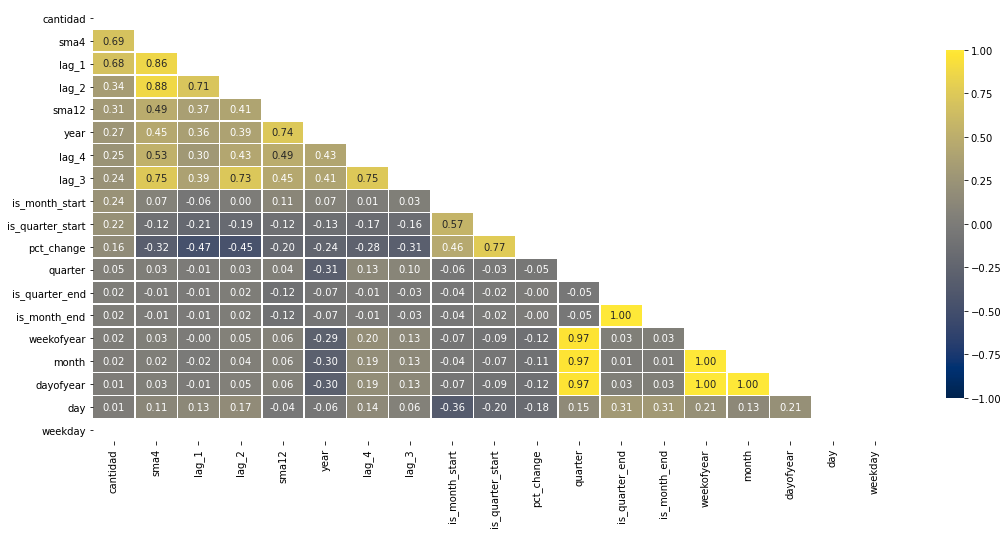

In [30]:
# Veriquemos la correlación entre las variables
correlaciones = data_period.corr().sort_values(by='cantidad', ascending=False).sort_values(by='cantidad', ascending=False, axis=1) 
mask = np.zeros_like(correlaciones, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(18,8))
sns.heatmap(correlaciones, mask=mask, fmt=".2f", vmin=-1, vmax=1, center=0, annot=True, cmap='cividis', linewidths=.4, cbar_kws={"shrink": .8})
plt.show()

#### Distribución de la demanda de combustible

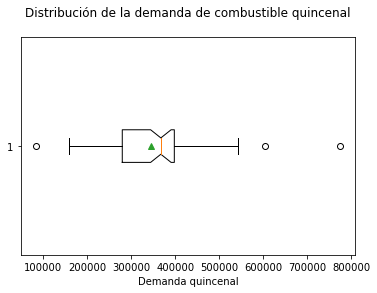

In [31]:
plt.boxplot(data_period['cantidad'], notch=True, showmeans=True, vert=False), plt.title('Distribución de la demanda de combustible quincenal\n')
plt.xlabel('Demanda quincenal')
plt.show()

In [32]:
data_period.columns

Index(['fecha_hora', 'producto', 'cantidad', 'segmento', 'year', 'month',
       'weekofyear', 'weekday', 'quarter', 'is_quarter_start',
       'is_quarter_end', 'day', 'dayofyear', 'is_month_start', 'is_month_end',
       'sma4', 'sma12', 'pct_change', 'lag_1', 'lag_2', 'lag_3', 'lag_4'],
      dtype='object')

## ENTRENAMIENTO Y TEST DE MODELOS

In [33]:
#============================================
# Función de entrenamiento y test de modelos
#============================================
def train_test_model(X, y, scaler=False):
    # Otra manera de escalar los datos (o la opción de normalize del algoritmo)
#     if scaler:
#         X_scaler = StandardScaler().fit_transform(X)
#         X.iloc[:,:] = X_scaler

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=False)
    model_LR = LinearRegression(normalize=scaler)
    model_LR.fit(X_train, y_train)
    y_pred_train = model_LR.predict(X_train)
    y_pred = model_LR.predict(X_test)
    metricas_train = {'R^2': round(r2_score(y_train, y_pred_train), 4), 'MSE': round(mean_squared_error(y_train, y_pred_train), 2), 
                     'MAE': round(mean_absolute_error(y_train, y_pred_train), 2), 'EVS': round(explained_variance_score(y_train, y_pred_train), 2), 
                     'MAD': round(median_absolute_error(y_train, y_pred_train), 2), 'ME': round(max_error(y_train, y_pred_train), 2)}
    metricas_test = {'R^2': round(r2_score(y_test, y_pred), 4), 'MSE': round(mean_squared_error(y_test, y_pred), 2), 
                     'MAE': round(mean_absolute_error(y_test, y_pred), 2), 'EVS': round(explained_variance_score(y_test, y_pred), 2), 
                     'MAD': round(median_absolute_error(y_test, y_pred), 2), 'ME': round(max_error(y_test, y_pred), 2)}

    print(f'Métricas de train del modelo:')
    print(pd.Series(metricas_train, name='valor').to_markdown(tablefmt="rst"))   # Requiere instalar tabulate
    print(f'\nMétricas de test del modelo:')
    print(pd.Series(metricas_test, name='valor').to_markdown(tablefmt="rst"), end='\n\n')  
    
    coef = pd.DataFrame(model_LR.coef_, index=X.columns, columns=['coefs'])
    coef = coef.sort_values(by=['coefs'], ascending=False)
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 0.6*len(coef)))
    ax.barh(coef.index, coef['coefs'])
    ax.set(xlabel='Coeficientes', ylabel='Variables', title='Valores de los coeficientes del modelo')
    plt.setp(ax.get_xticklabels(), rotation=60, horizontalalignment='right')
    plt.grid()
    
    return X_train, X_test, y_train, y_test, y_pred, model_LR

### Modelo 0

Métricas de train del modelo:
====  ================
..               valor
====  ================
R^2        0.2724
MSE        1.00351e+10
MAE    64002.7
EVS        0.27
MAD    42600.8
ME    439988
====  ================

Métricas de test del modelo:
====  ================
..               valor
====  ================
R^2       -0.9537
MSE        1.37703e+10
MAE    90183.4
EVS       -0.52
MAD    61644
ME    228479
====  ================



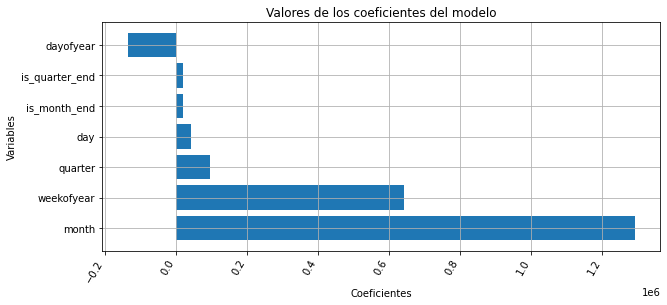

In [34]:
# Intentemos obtener un modelo con los siguientes features de menor correlación con la variable target
data_X = data_period.drop(columns=['cantidad', 'producto', 'segmento', 'fecha_hora'])
y = data_period['cantidad']
X = data_X[['quarter', 'is_quarter_end', 'is_month_end', 'weekofyear', 'month', 'dayofyear', 'day']]

X_train, X_test, y_train, y_test, y_pred, model_0 = train_test_model(X, y, False)

El valor del R^2 (coeficiente de determinación) debe fluctuar entre 0 y 1, ambos inclusive. Si la puntuación resulta negativa es porque el modelo es muy deficiente. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html

`Remember: "Garbage in, garbage out"`


Veamos las diferencias absolutas (diff) y porcentual (% var) entre el valor real y el predicho:

In [35]:
pd.DataFrame({'y_test': y_test,'y_pred': y_pred, 'diff': y_test - y_pred, '% var': (y_test - y_pred)/y_test*100})

,y_test,y_pred,diff,% var
48,386396.718750,380717.642574,5679.076176,1.469753
49,387962.250000,380550.081529,7412.168471,1.910539
50,408284.781250,371256.471058,37028.310192,9.069236
51,453226.593750,371088.910013,82137.683737,18.122874
52,407564.562500,448714.927472,-41150.364972,-10.096649
53,465977.093750,448547.366428,17429.727322,3.740469
54,494039.000000,395887.872329,98151.127671,19.867081
55,387619.781250,395720.311285,-8100.530035,-2.089813
56,460625.031250,429792.584440,30832.446810,6.693611
57,393418.875000,429625.023396,-36206.148396,-9.202952


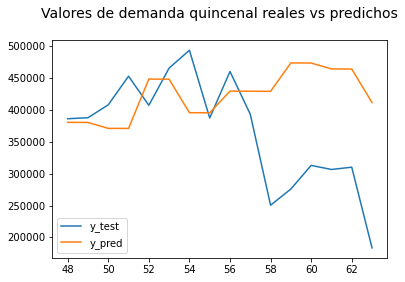

In [36]:
pd.DataFrame({'y_test': y_test,'y_pred': y_pred}).sort_index().plot()
plt.title('Valores de demanda quincenal reales vs predichos\n', fontsize=14)
plt.show()

### Modelo 1

Predictores: 
year, month, weekofyear, weekday, quarter, is_quarter_start, is_quarter_end, day, dayofyear, is_month_start, is_month_end, sma4, sma12, pct_change, lag_1, lag_2, lag_3, lag_4

Métricas de train del modelo:
====  ===============
..              valor
====  ===============
R^2       0.9634
MSE       5.05308e+08
MAE   14912.7
EVS       0.96
MAD    9685.15
ME    76602.9
====  ===============

Métricas de test del modelo:
====  ===============
..              valor
====  ===============
R^2       0.9139
MSE       6.06711e+08
MAE   21478.9
EVS       0.92
MAD   22735
ME    43611.5
====  ===============



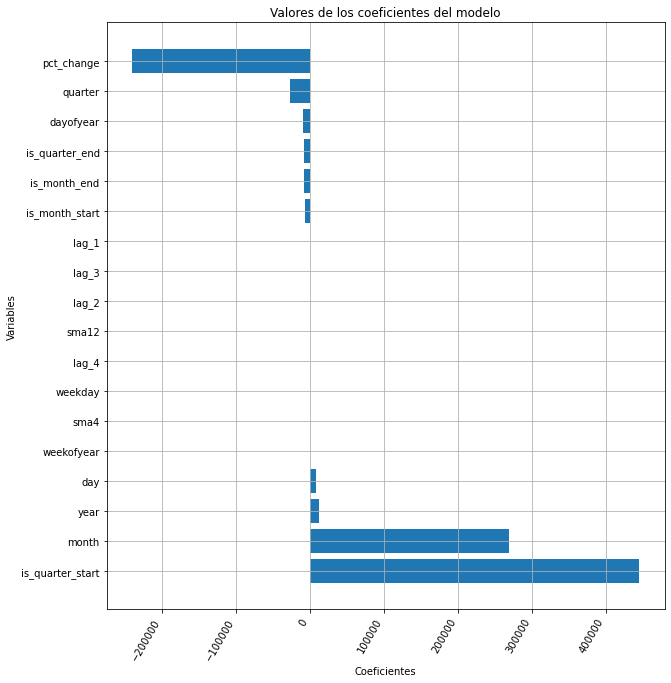

In [37]:
# Obtenemos un modelo con todos las variables regresoras
data_X = data_period.drop(columns=['cantidad', 'producto', 'segmento', 'fecha_hora'])
y = data_period['cantidad']
X = data_X
print('Predictores: ')
print(*X.columns, sep=', ', end='\n\n')
X_train, X_test, y_train, y_test, y_pred, model_1 = train_test_model(X, y, False)

In [38]:
pd.DataFrame({'y_test': y_test,'y_pred': y_pred, 'diff': y_test - y_pred, '% var': (y_test - y_pred)/y_test*100})

,y_test,y_pred,diff,% var
48,386396.718750,395590.770773,-9194.052023,-2.379433
49,387962.250000,401484.540713,-13522.290713,-3.485466
50,408284.781250,428553.371333,-20268.590083,-4.964327
51,453226.593750,478428.020734,-25201.426984,-5.560448
52,407564.562500,378634.001578,28930.560922,7.098400
53,465977.093750,436761.270987,29215.822763,6.269798
54,494039.000000,467298.471008,26740.528992,5.412635
55,387619.781250,370874.952115,16744.829135,4.319911
56,460625.031250,447465.494323,13159.536927,2.856887
57,393418.875000,393502.727991,-83.852991,-0.021314


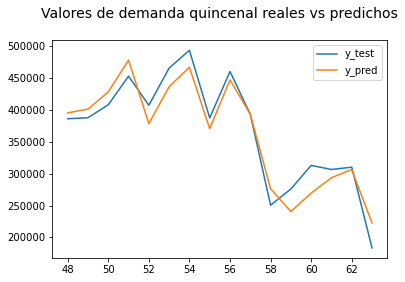

In [39]:
pd.DataFrame({'y_test': y_test,'y_pred': y_pred}).sort_index().plot()
plt.title('Valores de demanda quincenal reales vs predichos\n', fontsize=14)
plt.show()

### Modelo 2

Predictores: 
year, is_quarter_start, is_month_start, sma4, sma12, pct_change, lag_1, lag_2, lag_3, lag_4

Métricas de train del modelo:
====  ================
..               valor
====  ================
R^2        0.9502
MSE        6.87311e+08
MAE    15258.2
EVS        0.95
MAD     7957.66
ME    100005
====  ================

Métricas de test del modelo:
====  ===============
..              valor
====  ===============
R^2       0.9575
MSE       2.99821e+08
MAE   12616.4
EVS       0.96
MAD    6651.59
ME    41345.6
====  ===============



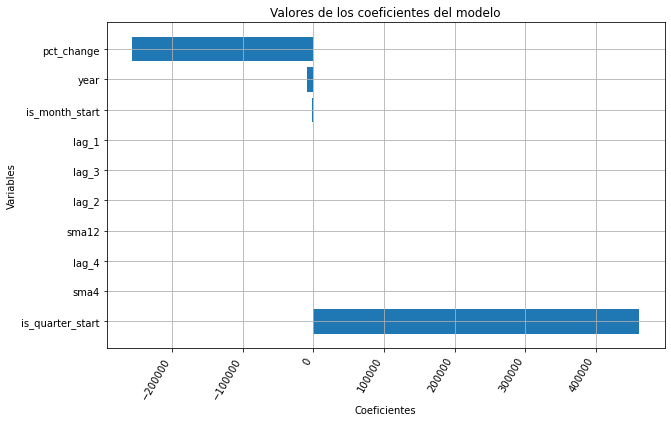

In [40]:
# Probemos a eliminar los features que tienen una correlación con el target nula y a lo sumo de 0.1
drop_cols = correlaciones.index[np.where((correlaciones.iloc[:,0] <= 0.1) | (correlaciones.iloc[:,0].isnull()))].tolist()
X = data_X.drop(columns=drop_cols)
print('Predictores: ')
print(*X.columns, sep=', ', end='\n\n')
X_train, X_test, y_train, y_test, y_pred, model_2 = train_test_model(X, y, False)

Se logra una mejora considerable del modelo.

La correlación de las variables regresoras o predictoras deben ser lo menor posible y la correlación de estas con la varibale target lo más significativa posible.

Aunque una alta correlación no significa que exista relación causa-efecto, es un punto de partida para el análisis.

Los valores de los coeficientes del modelo nos aporta un medio de análisis del efecto de una variable regresora sobre la variable target; estos proporcionan una medida marginal del cambio de la variable target cuando la variable regresora aumenta en una unidad (su signo nos da la dirección del cambio, - ó +, inversa o directamente proporcional).

Esta relación marginal es más significativa cuanto menor es la correlación entre variables regresoras (multicolinealidad).

**La multicolinealidad** ocurre cuando las variables predictoras en un modelo de regresión están correlacionadas de manera significativa entre sí.

Aunque la multicolinealidad *puede* causar problemas en la obtención del modelo, no siempre lo es. Por ello, se debe saber detectar cuando ésta sería un problema potencial. 

Pero, por otro lado, omitir una variable importante no solo reduce la bondad de ajuste, sino que también puede sesgar las estimaciones de los coeficientes.

In [41]:
pd.DataFrame({'y_test': y_test,'y_pred': y_pred, 'diff': y_test - y_pred, '% var': (y_test - y_pred)/y_test*100})

,y_test,y_pred,diff,% var
48,386396.718750,387674.017791,-1277.299041,-0.330567
49,387962.250000,386384.668627,1577.581373,0.406633
50,408284.781250,404774.703828,3510.077422,0.859713
51,453226.593750,448235.360029,4991.233721,1.101267
52,407564.562500,404954.148710,2610.413790,0.640491
53,465977.093750,458331.961868,7645.131882,1.640667
54,494039.000000,488915.372951,5123.627049,1.037090
55,387619.781250,393277.838201,-5658.056951,-1.459693
56,460625.031250,450924.694808,9700.336442,2.105907
57,393418.875000,391184.316789,2234.558211,0.567984


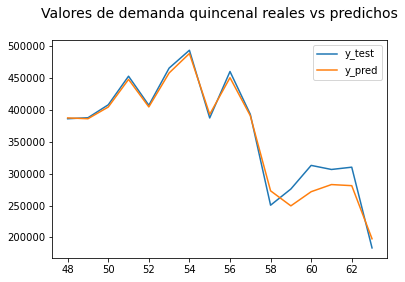

In [42]:
pd.DataFrame({'y_test': y_test,'y_pred': y_pred}).sort_index().plot()
plt.title('Valores de demanda quincenal reales vs predichos\n', fontsize=14)
plt.show()

### Modelo 3

Métricas de train del modelo:
====  ================
..               valor
====  ================
R^2        0.9155
MSE        1.16526e+09
MAE    22525.3
EVS        0.92
MAD    16427
ME    153086
====  ================

Métricas de test del modelo:
====  ===============
..              valor
====  ===============
R^2       0.9293
MSE       4.98173e+08
MAE   16877.3
EVS       0.94
MAD   11598.8
ME    43081.4
====  ===============



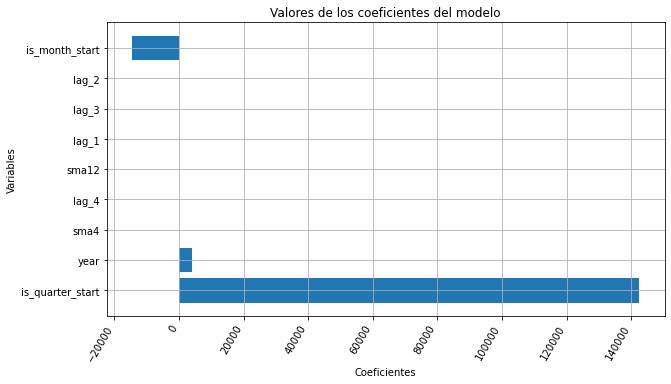

In [43]:
# Intentemos obtener un modelo con los features que mejor correlacionan con la variable target
X = data_X[correlaciones.index[np.where(correlaciones.iloc[:,0] > 0.20)][1:]]
X_train, X_test, y_train, y_test, y_pred, model_3 = train_test_model(X, y, False)

In [44]:
pd.DataFrame({'y_test': y_test,'y_pred': y_pred, 'diff': y_test - y_pred, '% var': (y_test - y_pred)/y_test*100})

,y_test,y_pred,diff,% var
48,386396.718750,387033.061477,-636.342727,-0.164686
49,387962.250000,387624.839742,337.410258,0.086970
50,408284.781250,405612.064834,2672.716416,0.654621
51,453226.593750,445509.056219,7717.537531,1.702799
52,407564.562500,428461.154729,-20896.592229,-5.127186
53,465977.093750,453083.855165,12893.238585,2.766925
54,494039.000000,504343.412382,-10304.412382,-2.085749
55,387619.781250,427955.023467,-40335.242217,-10.405878
56,460625.031250,428704.194433,31920.836817,6.929896
57,393418.875000,436500.265221,-43081.390221,-10.950514


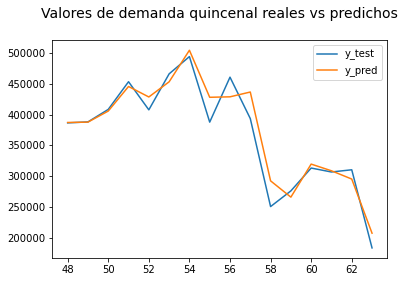

In [45]:
pd.DataFrame({'y_test': y_test,'y_pred': y_pred}).sort_index().plot()
plt.title('Valores de demanda quincenal reales vs predichos\n', fontsize=14)
plt.show()

### Modelo 4

Métricas de train del modelo:
====  ================
..               valor
====  ================
R^2        0.8707
MSE        1.78315e+09
MAE    30619.2
EVS        0.87
MAD    23826.2
ME    143333
====  ================

Métricas de test del modelo:
====  ===============
..              valor
====  ===============
R^2       0.7315
MSE       1.89279e+09
MAE   33253.2
EVS       0.77
MAD   29556
ME    96395.6
====  ===============



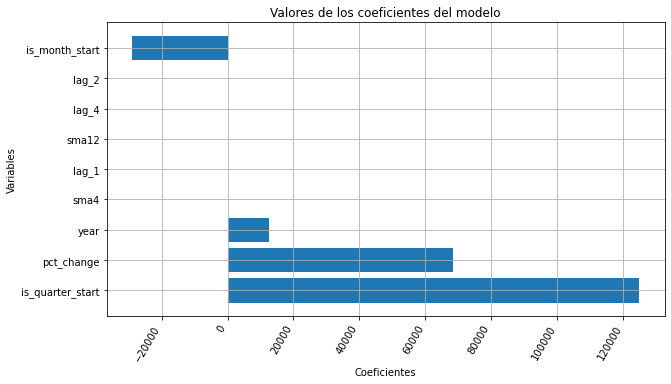

In [46]:
# Se prueba eliminar 'lag_3' debido a que presenta alta correlación con otros variables regresoras y baja correlación con la variable target
drop_cols = drop_cols + ['lag_3']
X = data_X.drop(columns=drop_cols)

X_train, X_test, y_train, y_test, y_pred, model_4 = train_test_model(X, y, False)

Al eliminar este predictor, se observa que el desempeño del modelo no mejora. Por lo que se puede conservar esta variable como input del modelo.

In [47]:
pd.DataFrame({'y_test': y_test,'y_pred': y_pred, 'diff': y_test - y_pred, '% var': (y_test - y_pred)/y_test*100})

,y_test,y_pred,diff,% var
48,386396.718750,380534.187717,5862.531033,1.517231
49,387962.250000,392639.625850,-4677.375850,-1.205627
50,408284.781250,402878.225487,5406.555763,1.324212
51,453226.593750,437242.904416,15983.689334,3.526644
52,407564.562500,447211.632121,-39647.069621,-9.727801
53,465977.093750,434654.259557,31322.834193,6.721969
54,494039.000000,521828.191974,-27789.191974,-5.624898
55,387619.781250,444564.765935,-56944.984685,-14.690939
56,460625.031250,392507.581611,68117.449639,14.788048
57,393418.875000,489814.469420,-96395.594420,-24.502026


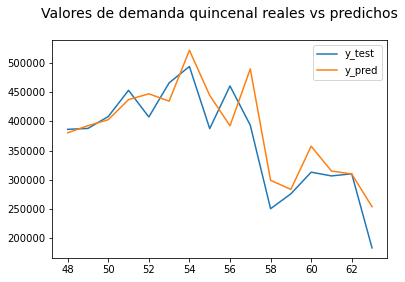

In [48]:
pd.DataFrame({'y_test': y_test,'y_pred': y_pred}).sort_index().plot()
plt.title('Valores de demanda quincenal reales vs predichos\n', fontsize=14)
plt.show()

**Multicolinealidad estructural**

Es la multicolinealidad causada por la creación de nuevos predictores a partir de otros predictores.

Una manera de tratar la multicolinealidad estructural es midiendo el Factor de Inflación de Varianza (VIF).

- Los valores del VIF comienzan en 1 y no tienen límite superior. 
- Un valor de 1 indica que no existe correlación entre esta variable independiente y cualquier otra. 
- Valores entre 1 y 5 sugieren que existe una correlación moderada, pero no es lo suficientemente severa como para justificar medidas correctivas. 
- Valores superiores a 5 representan niveles críticos de multicolinealidad donde los coeficientes están mal estimados y los valores p son cuestionables.

Para obtener el VIF en primer lugar ha de calcular la regresión lineal de una variable independiente frente a resto de variables independientes. Posteriormente se usa el $R^2$ de esta regresión para obtener el VIF de esta variable

$VIF = \frac{1}{1-R^2}$
 
Al fijarnos en la definición de VIF podemos ver que una variable independiente es realmente independiente del resto si el valor de VIF es igual a la unidad. Esto es el valor de $R^2$ es cero. 
Por otro lado, si el valor tiende a infinito la variable no es independiente, sino que se puede calcular a partir del resto de variables independientes.

Una de las maneras de tratar el problema de multicolinealidad consiste en centrar las variables regresoras, restando su media; o también escalando la variable. Aunque la primera facilita la interpretación de los coeficientes, ya que los coeficientes continúan representando el cambio medio en la variable dependiente dado un cambio de 1 unidad en la variable independiente.

---
---
Revisemos un poco sobre el tema:

Se calcula los factores de inflación de varianza para cada uno de las variables regresoras del último modelo obtenido. Observamos que algunos tienen valores de VIF mayores a 5.

In [49]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def get_vif(X_train):
    # VIF dataframe 
    vif_data = pd.DataFrame() 
    vif_data['feature'] = X_train.columns 

    # calculating VIF for each feature 
    vif_data['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(len(vif_data))]

    vif_data = vif_data.sort_values(['VIF']).reset_index(drop=True)
    return vif_data

vif_data = get_vif(X_train)
vif_data

,feature,VIF
0,is_month_start,2.163804
1,is_quarter_start,4.943689
2,pct_change,8.183658
3,lag_4,17.368669
4,lag_2,75.326607
5,year,83.709756
6,sma12,98.883893
7,lag_1,99.478888
8,sma4,401.755715


Ahora se escalan las variables regresoras y obtenemos de nuevo los valores de VIF. Observaremos que estos disminuirán de manera considerable para algunas variables.

Por otro lado se ve que los valores de los coeficientes del modelo de regresión han cambiado, son más significativos.

Sin embargo, las predicciones continuan siendo las mismas.

Métricas de train del modelo:
====  ================
..               valor
====  ================
R^2        0.8707
MSE        1.78315e+09
MAE    30619.2
EVS        0.87
MAD    23826.2
ME    143333
====  ================

Métricas de test del modelo:
====  ===============
..              valor
====  ===============
R^2       0.7315
MSE       1.89279e+09
MAE   33253.2
EVS       0.77
MAD   29556
ME    96395.6
====  ===============



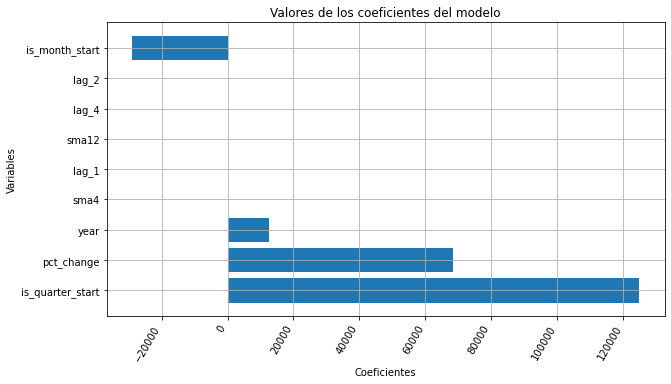

In [50]:
X_train, X_test, y_train, y_test, y_pred, model_4 = train_test_model(X, y, True)

In [51]:
vif_data = get_vif(X_train)
vif_data

,feature,VIF
0,is_month_start,2.163804
1,is_quarter_start,4.943689
2,pct_change,8.183658
3,lag_4,17.368669
4,lag_2,75.326607
5,year,83.709756
6,sma12,98.883893
7,lag_1,99.478888
8,sma4,401.755715


## PRONÓSTICO DE LA DEMANDA DIARIA DE COMBUSTIBLE

Desarrollar a partir de acá los puntos expuestos al inicio. (Teniendo en cuenta una periodicidad diaria)

## PRUEBA DE HIPERPARÁMETROS Y VALIDACIÓN CRUZADA

(Para este apartado utilizar otro algoritmo en el que puedan tener distintas opciones de hiperparámetros)